# MNIST Handwritten Digit classification

_Exercise: train an SVM classifier on the MNIST dataset. Since SVM classifiers are binary classifiers, you will need to use one-versus-all to classify all 10 digits. You may want to tune the hyperparameters using small validation sets to speed up the process. What accuracy can you reach?_

So lets train  on a dataset of handwritten numbers, with labels to tell us what the numbers should be. MNIST has 60,000 training examples, and 10,000 for testing.

First, let's load the dataset and split it into a training set and a test set. We could use `train_test_split()` but people usually just take the first 60,000 instances for the training set, and the last 10,000 instances for the test set (this makes it possible to compare your model's performance with others): 

## Download MNSIT Data
this might take a minute to download..retry if if fails


In [60]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")
X = mnist["data"]
y = mnist["target"]

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [ ]:
y_train

Many training algorithms are sensitive to the order of the training instances, so it's generally good practice to shuffle them first:

In [61]:
np.random.seed(42)
rnd_idx = np.random.permutation(60000)
X_train = X_train[rnd_idx]
y_train = y_train[rnd_idx]

## Train a linear SVM classifier

Let's start simple, with a linear SVM classifier. It will automatically use the One-vs-All (also called One-vs-the-Rest, OvR) strategy, so there's nothing special we need to do. Easy!

In [62]:
#might take a minute or two to train
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

Let's make predictions on the training set and measure the accuracy (we don't want to measure it on the test set yet, since we have not selected and trained the final model yet):

In [64]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.82633333333333336

Wow, 82% accuracy on MNIST is a really bad performance. This linear model is certainly too simple for MNIST, but perhaps we just needed to scale the data first:

## Standardize the data and put in a pipeline

Standardize the data and put in a pipeline

In [65]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [66]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [67]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(XXXXXX, XXXXXX)

0.9224

## Use non-linear kernels (RBFs, Polynomial?)

Put everything in a **pipeline**.

That's much better (we cut the error rate in two), but still not great at all for MNIST. If we want to use an SVM, we will have to use a kernel. Let's try an `SVC` with an RBF kernel (the default).

**Warning**: if you are using Scikit-Learn ≤ 0.19, the `SVC` class will use the One-vs-One (OvO) strategy by default, so you must explicitly set `decision_function_shape="ovr"` if you want to use the OvR strategy instead (OvR is the default since 0.19).

In [68]:
svm_clf = SVC(decision_function_shape="ovr")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [55]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.94615000000000005

## Tune hyperparameters

Put everything in a **pipeline**.

That's promising, we get better performance even though we trained the model on 6 times less data. Let's tune the hyperparameters by doing a randomized search with cross validation. We will do this on a small dataset just to speed up the process:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(XXXX, XXXXXX)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])  #### use a subset of the data to speed things up

In [57]:
rnd_search_cv.best_estimator_

SVC(C=8.8523160584230869, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001766074650481071,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [58]:
rnd_search_cv.best_score_

0.85599999999999998

This looks pretty low but remember we only trained the model on 1,000 instances. Let's retrain the best estimator on the whole training set (run this at night, it will take hours):

In [59]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=8.8523160584230869, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001766074650481071,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

Ah, this looks good! Let's select this model. Now we can test it on the test set:

In [61]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.97089999999999999

Not too bad, but apparently the model is overfitting slightly. It's tempting to tweak the hyperparameters a bit more (e.g. decreasing `C` and/or `gamma`), but we would run the risk of overfitting the test set. Other people have found that the hyperparameters `C=5` and `gamma=0.005` yield even better performance (over 98% accuracy). By running the randomized search for longer and on a larger part of the training set, you may be able to find this as well.

# Regression

Using the California housing dataset train and tune up an SVM regressor pipeline. Is your best SVR pipeline statistically significantly better than randomforests?

For information on the see [here](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html)

* This dataset consists of 20,640 samples and 9 features.


## Download data and do EDA

Let's load the dataset using Scikit-Learn's `fetch_california_housing()` function:

In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

In [3]:
housing.DESCR

'California housing dataset.\n\nThe original database is available from StatLib\n\n    http://lib.stat.cmu.edu/\n\nThe data contains 20,640 observations on 9 variables.\n\nThis dataset contains the average house value as target variable\nand the following input variables (features): average income,\nhousing average age, average rooms, average bedrooms, population,\naverage occupation, latitude, and longitude in that order.\n\nReferences\n----------\n\nPace, R. Kelley and Ronald Barry, Sparse Spatial Autoregressions,\nStatistics and Probability Letters, 33 (1997) 291-297.\n\n'

In [6]:
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

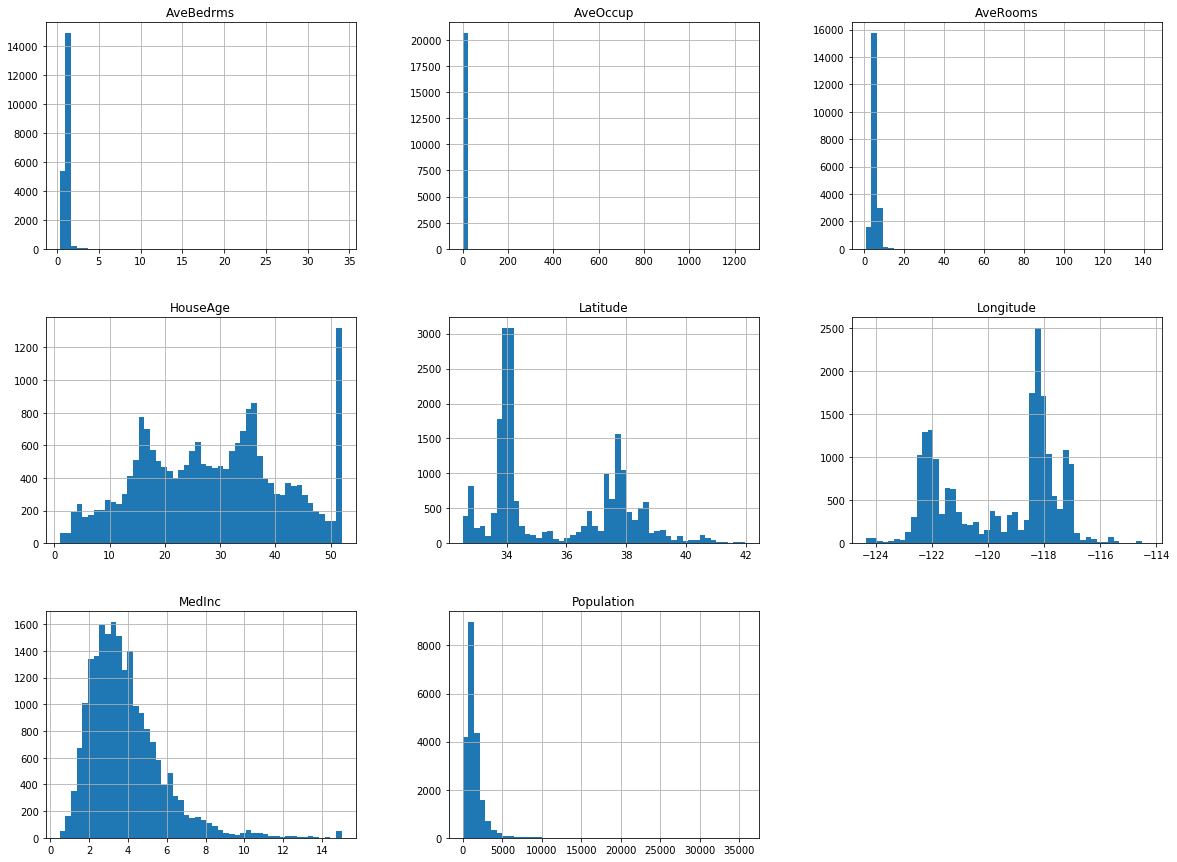

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd

df=pd.DataFrame(X, columns=housing.feature_names)
df.hist(bins=50, figsize=(20,15))
plt.show()

In this training set, the targets are hundreds of thousands of dollars. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f66eed6dcc0>]], dtype=object)

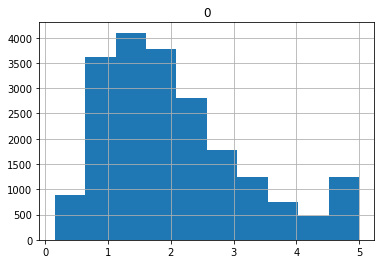

In [10]:
# Plot Target variable
# Target variable has been scaled by $100,000
pd.DataFrame(y).hist()

Split it into a training set and a test set:

In [63]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Build a baseline pipeline

Don't forget to scale the data and use pipeline. Add pipelines here.

In [64]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Let's train a simple `LinearSVR` first:

In [65]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=42, tol=0.0001, verbose=0)

Let's see how it performs on the training set:

In [66]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

0.94996882221722923

Let's look at the RMSE:

In [67]:
np.sqrt(mse)

0.97466344048457532

In this training set, the targets are tens of thousands of dollars. The RMSE gives a rough idea of the kind of error you should expect (with a higher weight for large errors): so with this model we can expect errors somewhere around $100,000. Not great. 

## Tune hyperparameters of SVR
Let's see if we can do better with an RBF Kernel. We will use randomized search with cross validation to find the appropriate hyperparameter values for `C` and `gamma`:

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(XXXXXXXXX), "C": uniform(XXXX, XXXX)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

In [69]:
rnd_search_cv.best_estimator_

SVR(C=4.7454011884736254, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.079694548186439285, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False)

Now let's measure the RMSE on the training set:

In [70]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.5727524770785356

Looks much better than the linear model. Let's select this model and evaluate it on the test set:

In [71]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.59291683855287403

## TASK: Contrast with a random forest with 100 decision trees with a depth of 10.

# [Optional] Extend Linear SVM classifier via BGD to multiple classes

Extend the following implementation of a Linear SVM classifier via batch gradient descent to case there deals with 3 or more   classes.

Adopt all the code and experiments in this section and modify as needed to classify the 3-class iris dataset on 2=dimensional input space (petal length, petal width).


## Training set
X = iris["data"][:, (2, 3)] # petal length, petal width


In [50]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1) # n feature weights
        b = 0

        m = len(X)
        t = y * 2 - 1  # -1 if t==0, +1 if t==1
        X_t = X * t
        self.Js=[]

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.Js.append(J)

            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            b_derivative = -C * np.sum(t_sv)
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[ 1.],
       [ 0.]])

[0, 60000, 0, 100]

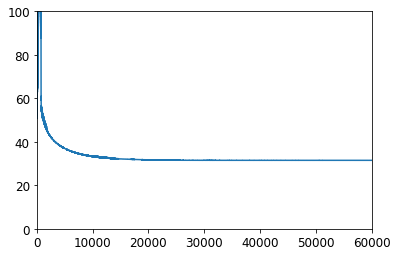

In [51]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])

In [52]:
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56780998] [[[ 2.28129013]
  [ 2.71597487]]]


In [53]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[ 2.27128546  2.71287145]]


[4, 6, 0.8, 2.8]

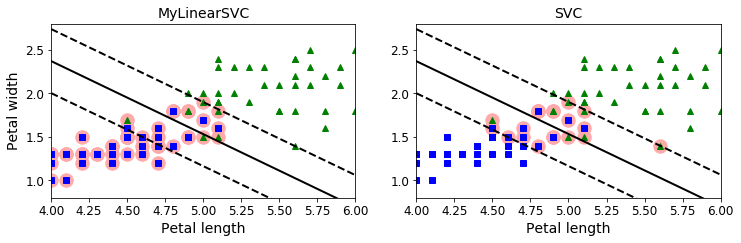

In [54]:
yr = y.ravel()
plt.figure(figsize=(12,3.2))
plt.subplot(121)
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris-Virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris-Virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])

plt.subplot(122)
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


[-14.062485     2.24179316   1.79750198]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[4, 6, 0.8, 2.8]

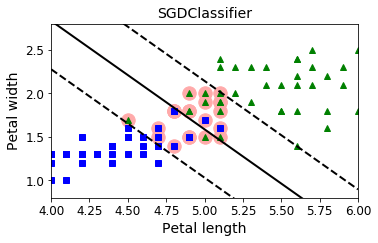

In [55]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha = 0.017, n_iter = 50, random_state=42)
sgd_clf.fit(X, y.ravel())

m = len(X)
t = y * 2 - 1  # -1 if t==0, +1 if t==1
X_b = np.c_[np.ones((m, 1)), X]  # Add bias input x0=1
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


## compare homegrown with LinearSVC and SVC 

_Exercise: train a `LinearSVC` on a linearly separable dataset. Then train an `SVC` and a `SGDClassifier` on the same dataset. See if you can get them to produce roughly the same model._

Let's use the Iris dataset: the Iris Setosa and Iris Versicolor classes are linearly separable.

In [56]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [57]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        n_iter=100000, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:73: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


LinearSVC:                    [ 0.28480668] [[ 1.05542422  1.09851637]]
SVC:                          [ 0.31933577] [[ 1.1223101   1.02531081]]
SGDClassifier(alpha=0.00200): [ 0.32] [[ 1.12293103  1.02620763]]


Let's plot the decision boundaries of these three models:

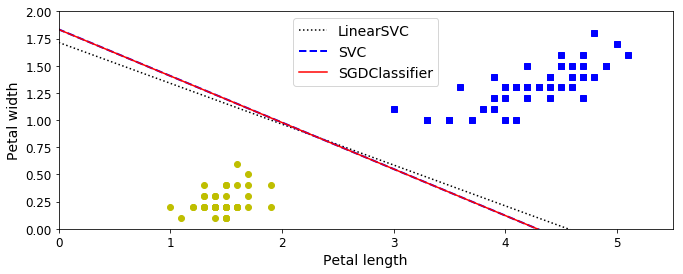

In [58]:
# Compute the slope and bias of each decision boundary
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# Transform the decision boundary lines back to the original scale
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# Plot all three decision boundaries
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris-Versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris-Setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

Close enough!